# Initialisations, activations et normalisations

Suite de l'implémentation d'un réseau de neurones de type _Feed-Forward Network_ inspiré du papier de Bengio et al. de 2003 [_A Neural Probabilistic Language Model_](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

Étude des initialisations, des fonctions d'activation et de la normalisation.


Bibliographie indicative:

- "Kaiming init": <https://arxiv.org/abs/1502.01852>
- BatchNorm: <https://arxiv.org/abs/1502.03167>
- Illustration de certains problèmes liés à BatchNorm: <https://arxiv.org/abs/2105.07576>

## Restructuration du code précédent

In [4]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Words

In [5]:
class Words(object):
    """Représente une liste de mots, ainsi que la liste ordonnée des caractères les composants."""

    EOS = '.'

    def __init__(self, filename):
        self.filename = filename
        self.words = open(self.filename, 'r').read().splitlines()
        self.nb_words = len(self.words)
        self.chars = sorted(list(set(''.join(self.words))))
        self.nb_chars = len(self.chars) + 1  # On ajoute 1 pour EOS
        self.ctoi = {c:i+1 for i,c in enumerate(self.chars)}
        self.ctoi[self.EOS] = 0
        self.itoc = {i:s for s,i in self.ctoi.items()}

    def __repr__(self):
        l = []
        l.append("<Words")
        l.append(f'  filename="{self.filename}"')
        l.append(f'  nb_words="{self.nb_words}"')
        l.append(f'  nb_chars="{self.nb_chars}"/>')
        return '\n'.join(l)

In [6]:
words = Words('civil_mots.txt')
print(words)

<Words
  filename="civil_mots.txt"
  nb_words="7223"
  nb_chars="41"/>


### Datasets

In [7]:

class Datasets:
    """Construits les jeu de données d'entraînement, de test et de validation.
    
    Prend en paramètres une liste de mots et la taille du contexte pour la prédiction.
    """

    def _build_dataset(self, lwords:list, context_size:int):
        X, Y = [], []
        for w in lwords:
            context = [0] * context_size
            for ch in w + self.words.EOS:
                ix = self.words.ctoi[ch]
                X.append(context)
                Y.append(ix)
                context = context[1:] + [ix] # crop and append
        X = torch.tensor(X)
        Y = torch.tensor(Y)
        return X, Y
    
    def __init__(self, words:Words, context_size:int, seed:int=42):
        # 80%, 10%, 10%
        self.shuffled_words = words.words.copy()
        random.shuffle(self.shuffled_words)
        self.n1 = int(0.8*len(self.shuffled_words))
        self.n2 = int(0.9*len(self.shuffled_words))
        self.words = words
        self.Xtr, self.Ytr = self._build_dataset(self.shuffled_words[:self.n1], context_size)
        self.Xdev, self.Ydev = self._build_dataset(self.shuffled_words[self.n1:self.n2], context_size)
        self.Xte, self.Yte = self._build_dataset(self.shuffled_words[self.n2:], context_size)


In [8]:
context_size = 3
datasets = Datasets(words, context_size)

### Réseau de neurones à propagation avant (Feed-Forward Network)

In [ ]:
class BengioFFN:
    
    def __init__(self, e_dims, n_hidden, context_size, nb_chars, g):
        self.g = g
        self.nb_chars = nb_chars
        self.e_dims = e_dims
        self.n_hidden = n_hidden
        self.context_size = context_size
        self.create_network()

    def layers(self):
        self.C = torch.randn((self.nb_chars, self.e_dims), generator=self.g)
        self.W1 = torch.randn((self.context_size * self.e_dims, self.n_hidden), generator=self.g)
        self.b1 = torch.randn(self.n_hidden, generator=self.g)
        self.W2 = torch.randn((self.n_hidden, self.nb_chars), generator=self.g)
        self.b2 = torch.randn(self.nb_chars, generator=self.g)

    def create_network(self):
        self.layers()
        self.loss = None
        self.steps = 0
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        self.nb_parameters = sum(p.nelement() for p in self.parameters) # number of parameters in total
        for p in self.parameters:
            p.requires_grad = True

    def forward(self, X, Y):
        self.emb = self.C[X] # Embed characters into vectors
        self.embcat = self.emb.view(self.emb.shape[0], -1) # Concatenate the vectors
        self.hpreact = self.embcat @ self.W1 + self.b1 # hidden layer pre-activation
        self.h = torch.tanh(self.hpreact) # hidden layer
        self.logits = self.h @ self.W2 + self.b2 # output layer
        self.loss = F.cross_entropy(self.logits, Y) # loss function

    def backward(self):
        for p in self.parameters:
            p.grad = None
        self.loss.backward()

    def train(self, datasets: Datasets, max_steps, mini_batch_size):
        lossi = []
        for i in range(max_steps):
            # minibatch construct
            ix = torch.randint(0, datasets.Xtr.shape[0], (mini_batch_size,), generator=self.g)
            Xb, Yb = datasets.Xtr[ix], datasets.Ytr[ix]
            
            # forward pass
            self.forward(Xb, Yb)
        
            # backward pass
            self.backward()
        
            # update
            lr = 0.2 if i < 100000 else 0.02 # step learning rate decay
            self.update_grad(lr)
        
            # track stats
            if i % 10000 == 0:
                print(f"{i:7d}/{max_steps:7d}: {self.loss.item():.4f}")
            lossi.append(self.loss.log10().item())
        self.steps += max_steps
        return lossi

    def update_grad(self, lr):
        for p in self.parameters:
            p.data += -lr * p.grad

    @torch.no_grad() # this decorator disables gradient tracking
    def compute_loss(self, X, Y):
        emb = self.C[X] # Embed characters into vectors
        embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
        hpreact = embcat @ self.W1 + self.b1 # hidden layer pre-activation
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ self.W2 + self.b2 # output layer
        loss = F.cross_entropy(logits, Y) # loss function
        return loss

    @torch.no_grad() # this decorator disables gradient tracking
    def training_loss(self, datasets:Datasets):
        loss = self.compute_loss(datasets.Xtr, datasets.Ytr)
        return loss.item()

    @torch.no_grad() # this decorator disables gradient tracking
    def test_loss(self, datasets:Datasets):
        loss = self.compute_loss(datasets.Xte, datasets.Yte)
        return loss.item()

    @torch.no_grad() # this decorator disables gradient tracking
    def dev_loss(self, datasets:Datasets):
        loss = self.compute_loss(datasets.Xdev, datasets.Xdev)
        return loss.item()

    @torch.no_grad()
    def generate_word(self, itoc, g):
        out = []
        context = [0] * self.context_size
        while True:
            emb = self.C[torch.tensor([context])]
            h = torch.tanh(emb.view(1, -1) @ self.W1 + self.b1)
            logits = h @ self.W2 + self.b2
            probs = F.softmax(logits, dim=1)
            # Sample from the probability distribution
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            # Shift the context window
            context = context[1:] + [ix]
            # Store the generated character
            if ix != 0:
                out.append(ix)
            else:
                # Stop when encounting '.'
                break
        return ''.join(itoc[i] for i in out)

    def __repr__(self):
        l = []
        l.append("<BengioMLP")
        l.append(f'  nb_chars="{self.nb_chars}"')
        l.append(f'  e_dims="{self.e_dims}"')
        l.append(f'  n_hidden="{self.n_hidden}"')
        l.append(f'  context_size="{self.context_size}"')
        l.append(f'  loss="{self.loss}"')
        l.append(f'  steps="{self.steps}"')
        l.append(f'  nb_parameters="{self.nb_parameters}"/>')
        return '\n'.join(l)

In [10]:
e_dims = 10  # Dimensions des embeddings
n_hidden = 200
seed = 2147483647
g = torch.Generator().manual_seed(seed)
nn = BengioFFN(e_dims, n_hidden, context_size, words.nb_chars, g)
print(nn)

<BengioMLP
  nb_chars="41"
  e_dims="10"
  n_hidden="200"
  context_size="3"
  loss="None"
  steps="0"
  nb_parameters="14851"/>


### Apprentissage

In [11]:
max_steps = 200000
mini_batch_size = 32
lossi = nn.train(datasets, max_steps, mini_batch_size) 

      0/ 200000: 30.4901
  10000/ 200000: 2.1505
  20000/ 200000: 1.5062
  30000/ 200000: 1.9053
  40000/ 200000: 1.8812
  50000/ 200000: 2.8604
  60000/ 200000: 2.1297
  70000/ 200000: 1.6733
  80000/ 200000: 2.1570
  90000/ 200000: 1.7283
 100000/ 200000: 1.9989
 110000/ 200000: 1.5019
 120000/ 200000: 1.2979
 130000/ 200000: 1.5895
 140000/ 200000: 1.6045
 150000/ 200000: 1.8367
 160000/ 200000: 1.7854
 170000/ 200000: 1.1291
 180000/ 200000: 1.7075
 190000/ 200000: 1.4321


In [12]:
print(nn)

<BengioMLP
  nb_chars="41"
  e_dims="10"
  n_hidden="200"
  context_size="3"
  loss="1.25055730342865"
  steps="200000"
  nb_parameters="14851"/>


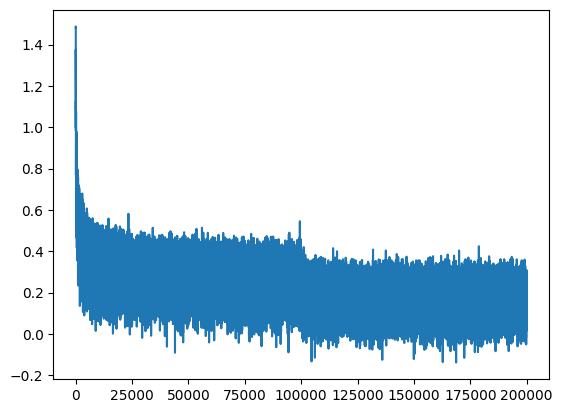

In [13]:
plt.plot(lossi);

In [14]:
train_loss = nn.training_loss(datasets)
val_loss = nn.test_loss(datasets)
print(f"{train_loss=}")
print(f"{val_loss=}")

train_loss=1.4996627569198608
val_loss=1.7031011581420898


### Génération de mots

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    word = nn.generate_word(words.itoc, g)
    print(word)

aveilles
saienti
pénies
ints
apprés
précieursulte
expulsé
pournile
achement
citressort
résignemention
moyés
soumonial
hement
crivéalis
memblateurs
résent
qu'aucontribunifiencé
prendu
dété


## Discussion sur l'inititialisation et la normalisation des couches

### Loss initial

Notre réseau est en fait mal initialisé, avec les valeurs aléatoires que nous avons choisies.
On peut s'en rendre compte en lançant une seule itération d'apprentissage et en regardant le score de _loss_.

In [18]:
g = torch.Generator().manual_seed(seed)
nn = BengioFFN(e_dims, n_hidden, context_size, words.nb_chars, g)
lossi = nn.train(datasets, 1, mini_batch_size)

      0/      1: 30.4901


Nous avons une valeur de près de 30. Quelle valeur pourrions nous attendre? À l'initialisation, nous aimerions que chacun des 41 caractères aient une équiprobabilité de 1/41 d'apparaître après une suite de 3 caractères donnée, soit une distribution uniforme, car le réseau n'a encore vu aucun example.

In [19]:
1/41

0.024390243902439025

Le _loss_ devrait donc être aux alentours de 3.736:

In [25]:
-torch.tensor(1/41.0).log().item()

3.7135720252990723

Définissons une fonction `comp_loss` qui va nous permettre d'obtenir le _loss_ pour l'élément numéro `item` à partir des logits `l`:

In [37]:
def comp_loss(l:list, item:int):
    # Calcule le loss associé à l'item dans la distribution de probabilité
    # associée au logits
    logits = torch.tensor(l)
    probs = torch.softmax(logits, dim=0)
    loss = -probs[item].log()
    return logits, probs, loss.item()

In [38]:
# Distributions uniformes
print(comp_loss([0.0, 0.0, 0.0, 0.0], 2))
print(comp_loss([1.0, 1.0, 1.0, 1.0], 2))

(tensor([0., 0., 0., 0.]), tensor([0.2500, 0.2500, 0.2500, 0.2500]), 1.3862943649291992)
(tensor([1., 1., 1., 1.]), tensor([0.2500, 0.2500, 0.2500, 0.2500]), 1.3862943649291992)


In [39]:
# Loss très faible car on sélectionne l'item qui a le logit le plus élevé
print(comp_loss([0.0, 0.0, 10.0, 0.0], 2))
print(comp_loss([0.0, 0.0, 10000.0, 0.0], 2))


(tensor([ 0.,  0., 10.,  0.]), tensor([4.5394e-05, 4.5394e-05, 9.9986e-01, 4.5394e-05]), 0.00013626550207845867)
(tensor([    0.,     0., 10000.,     0.]), tensor([0., 0., 1., 0.]), -0.0)


In [41]:
# Valeurs disparates
print(comp_loss([-3.0, 5.0, 0.0, -5.0], 2))
print(comp_loss([100.0, 50.0, 5.0, -45.0], 2))


(tensor([-3.,  5.,  0., -5.]), tensor([3.3309e-04, 9.9293e-01, 6.6903e-03, 4.5079e-05]), 5.00709342956543)
(tensor([100.,  50.,   5., -45.]), tensor([1.0000e+00, 1.9287e-22, 5.5211e-42, 0.0000e+00]), 94.99999237060547)


In [56]:
print(comp_loss((torch.randn(4) * 10).tolist(), 2))

(tensor([13.4427, -0.7880, -7.3284,  1.1521]), tensor([9.9999e-01, 6.6022e-07, 9.5328e-10, 4.5945e-06]), 20.7711124420166)


Il nous faut donc une initialisation différente pour ne pas avoir ce loss élevé au début, qui donne une courbe en forme de "crosse de hockey" caractéristique.

In [57]:
g = torch.Generator().manual_seed(seed)
nn = BengioFFN(e_dims, n_hidden, context_size, words.nb_chars, g)
lossi = nn.train(datasets, 1, mini_batch_size)
print(nn.logits[0])

      0/      1: 30.4901
tensor([  4.6166,   7.7147,  15.4573,   1.0207,  -2.7009,  -5.7819,  -5.3783,
         23.6806,  21.1588,  -2.8979,  -4.8657, -11.5645,   8.7837,   4.6332,
        -13.9403, -13.4483,  -3.9130,   1.4592,   8.2284,  10.1325, -16.5248,
         -7.4705, -14.2061,  -4.3193,   0.8513, -11.2382,  30.9323,   1.3783,
         -6.4384,  26.5325, -14.2742,  14.5535,   4.6325,  21.9473,  14.6677,
         18.3815,  -1.1816,   1.2932,   7.4166,  -7.3696, -19.7648],
       grad_fn=<SelectBackward0>)


Dans la classe `BengioFFN` définie ci-dessus, les logits sont obtenus par l'expression:

```python
self.logits = self.h @ self.W2 + self.b2 # output layer
```

avec `W2` et `b2` initialisés de la façons suivante:

```python
self.W2 = torch.randn((self.n_hidden, self.nb_chars), generator=self.g)
self.b2 = torch.randn(self.nb_chars, generator=self.g)
```

Nous allons donc modifier la méthode `layers()` où se trouve cette initialisation de la façon suivante:

In [61]:
def layers(self):
    self.C = torch.randn((self.nb_chars, self.e_dims), generator=self.g)
    self.W1 = torch.randn((self.context_size * self.e_dims, self.n_hidden), generator=self.g)
    self.b1 = torch.randn(self.n_hidden, generator=self.g)
    self.W2 = torch.randn((self.n_hidden, self.nb_chars), generator=self.g) * 0.01  # Pour l'entropie
    self.b2 = torch.randn(self.nb_chars, generator=self.g) * 0
BengioFFN.layers = layers

In [62]:
g = torch.Generator().manual_seed(seed)
nn = BengioFFN(e_dims, n_hidden, context_size, words.nb_chars, g)
lossi = nn.train(datasets, 1, mini_batch_size)
print(nn.logits[0])

      0/      1: 3.7308
tensor([ 0.0420,  0.0911,  0.1608, -0.0033, -0.0175, -0.0748, -0.0536,  0.2406,
         0.2165, -0.0141, -0.0452, -0.1238,  0.0900,  0.0641, -0.1163, -0.1273,
        -0.0343, -0.0122,  0.0917,  0.1035, -0.1610, -0.0921, -0.1565, -0.0330,
        -0.0077, -0.0974,  0.3215,  0.0067, -0.0524,  0.2585, -0.1674,  0.1523,
         0.0457,  0.2221,  0.1550,  0.1901, -0.0024,  0.0209,  0.0841, -0.0792,
        -0.1927], grad_fn=<SelectBackward0>)


On a maintenant un loss initial qui est proche de ce que nous voulons. Réentrainons complètement le modèle.

In [63]:
g = torch.Generator().manual_seed(seed)
nn = BengioFFN(e_dims, n_hidden, context_size, words.nb_chars, g)
lossi = nn.train(datasets, max_steps, mini_batch_size)

      0/ 200000: 3.7308
  10000/ 200000: 1.9096
  20000/ 200000: 1.4936
  30000/ 200000: 1.7350
  40000/ 200000: 1.5614
  50000/ 200000: 2.4063
  60000/ 200000: 1.5985
  70000/ 200000: 1.6582
  80000/ 200000: 2.1206
  90000/ 200000: 1.4665
 100000/ 200000: 1.7602
 110000/ 200000: 1.7375
 120000/ 200000: 1.3745
 130000/ 200000: 1.4203
 140000/ 200000: 1.6508
 150000/ 200000: 1.6507
 160000/ 200000: 1.6627
 170000/ 200000: 1.1234
 180000/ 200000: 1.5974
 190000/ 200000: 1.3893


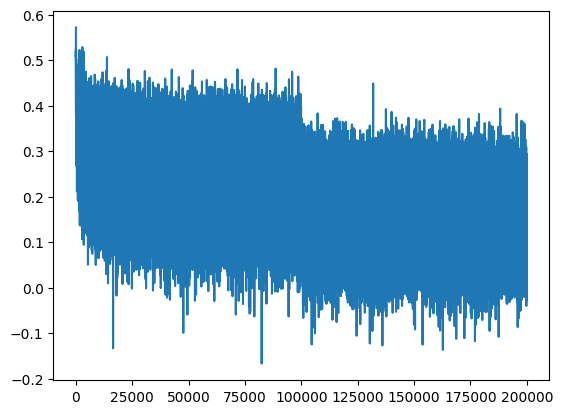

In [64]:
plt.plot(lossi);

In [65]:
train_loss = nn.training_loss(datasets)
val_loss = nn.test_loss(datasets)
print(f"{train_loss=}")
print(f"{val_loss=}")

train_loss=1.4785451889038086
val_loss=1.6728813648223877


### Squashing via tanh

Il y a potentiellement un problème avec la couche cachée `h` et sa fonction d'activation `tanh` qui "squashe" les valeurs.

```python
self.hpreact = self.embcat @ self.W1 + self.b1 # hidden layer pre-activation
self.h = torch.tanh(self.hpreact) # hidden layer
```

In [66]:
g = torch.Generator().manual_seed(seed)
nn = BengioFFN(e_dims, n_hidden, context_size, words.nb_chars, g)
lossi = nn.train(datasets, 1, mini_batch_size)
nn.h

      0/      1: 3.7308


tensor([[-1.0000, -0.9998, -0.9985,  ..., -0.9964,  1.0000,  0.9995],
        [-1.0000,  0.9432, -0.9935,  ...,  0.9990,  0.9751, -0.9991],
        [-1.0000, -0.9998, -0.9985,  ..., -0.9964,  1.0000,  0.9995],
        ...,
        [-1.0000, -0.9995,  0.9973,  ..., -0.9959,  0.9997, -0.9979],
        [-1.0000,  1.0000, -0.9998,  ..., -0.3458,  1.0000,  1.0000],
        [ 0.9631, -0.9770,  1.0000,  ..., -0.8631,  0.9987, -0.8641]],
       grad_fn=<TanhBackward0>)

On peut voir qu'il y a beaucoup de valeurs à 1 ou -1. C'est `tanh` qui "squashe" des valeurs. Est-elle trop active?

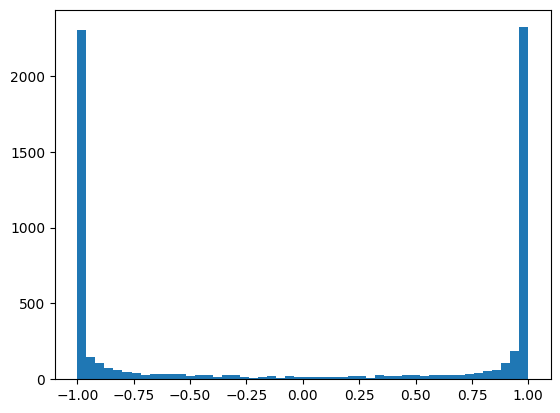

In [69]:
# Histogramme des valeurs de la couche `h`
plt.hist(nn.h.view(-1).tolist(), 50);

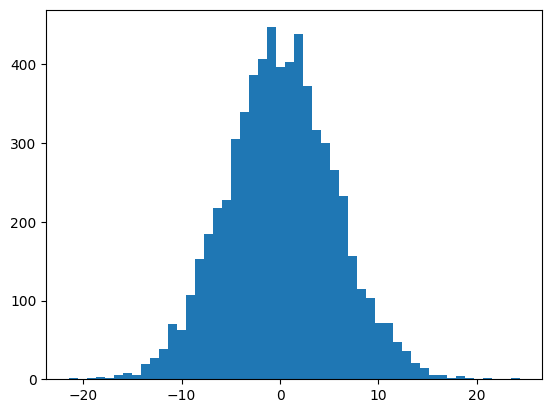

In [72]:
# Histogramme des valeurs de la couche `h`
plt.hist(nn.hpreact.view(-1).tolist(), 50);

La distribution de valeurs est trop large. Beaucoup de nombres prennent des valeurs extrêmes, ce qui a un impact sur la qualité finale du réseau: beaucoup de valeurs passant "à travers" cette couche du réseau en remontant lors de la propagation arrière sont supprimées.

Que se passe t'il dans le réseau quand tanh vaut -1 ou 1? En reprenant le code que nous avions implémenté pour la rétropropagation:

```python
def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, children=(self,), op='tanh')
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out
```

La valeur calculée $t$ est comprise entre $-1$ et $1$ ($\mathrm{tanh}$). Lors du calcul du gradient local, quand $t$ est proche de $-1$ ou $1$, on va "tuer" le gradient puisque $1-t^2$ sera égal à 0 et on va donc stopper la propagation arrière ici.

On peut améliorer cette situation, tout d'abord en visualisant tous les cas où les valeurs de `h` sont dans une région "plate" de la fonction $tanh$ (proches de $-1$ ou $1$), les cases blanches étant celles où c'est le cas:

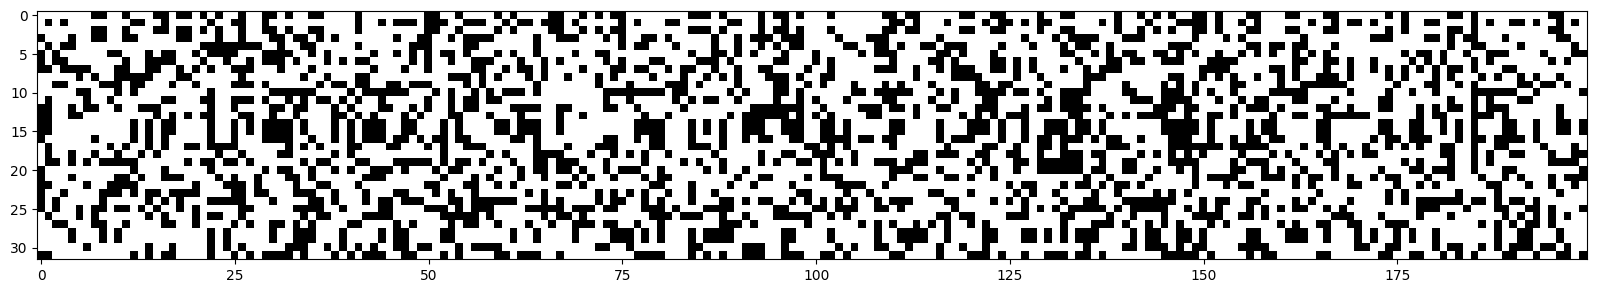

In [73]:
plt.figure(figsize=(20,10))
plt.imshow(nn.h.abs() > 0.99, cmap='gray', interpolation='nearest');

Si nous avions une colonne avec uniquement des cases blanches, cela signifierait que le neurone est mort et qu'il ne participe plus au fonctionnement général (aucun exemple ne l'a jamais activé), il n'apprendra plus ("_permanent brain damage_"). Cela ne semble pas être le cas ici.

Ce comportement n'est pas propre à la fonction $tanh$ et se retrouve dans toutes les [fonctions d'activation](https://fr.wikipedia.org/wiki/Fonction_d'activation).

Même si cette manière d'initialiser le réseau donne un _loss_ acceptable, il peut être amélioré en faisant en sorte qu'il y a ait moins de cases blanches: une manière de faire ceci est de réduire la plage de valeurs prises par la fonction de pré-activation `hpreact` et de faire en sorte que ces valeurs soient plus proches de 0.

In [102]:
def layers(self):
    self.C = torch.randn((self.nb_chars, self.e_dims), generator=self.g)
    self.W1 = torch.randn((self.context_size * self.e_dims, self.n_hidden), generator=self.g) * 0.2
    self.b1 = torch.randn(self.n_hidden, generator=self.g) * 0.01  # un peu d'entropie
    self.W2 = torch.randn((self.n_hidden, self.nb_chars), generator=self.g) * 0.01  # Pour l'entropie
    self.b2 = torch.randn(self.nb_chars, generator=self.g) * 0
BengioFFN.layers = layers

In [82]:
g = torch.Generator().manual_seed(seed)
nn = BengioFFN(e_dims, n_hidden, context_size, words.nb_chars, g)
lossi = nn.train(datasets, 1, mini_batch_size)
print(nn.h)


      0/      1: 3.7371
tensor([[-0.9646, -0.6130, -0.8121,  ..., -0.6439,  0.7729,  0.7591],
        [-0.8748,  0.5015, -0.7546,  ...,  0.5581,  0.2301, -0.5421],
        [-0.9646, -0.6130, -0.8121,  ..., -0.6439,  0.7729,  0.7591],
        ...,
        [-0.7323, -0.5527,  0.2453,  ..., -0.6356,  0.5811, -0.4778],
        [-0.9943,  0.9848, -0.8656,  ..., -0.2016,  0.9336,  0.9865],
        [ 0.5922, -0.2423,  0.9416,  ..., -0.3742,  0.4832, -0.0968]],
       grad_fn=<TanhBackward0>)


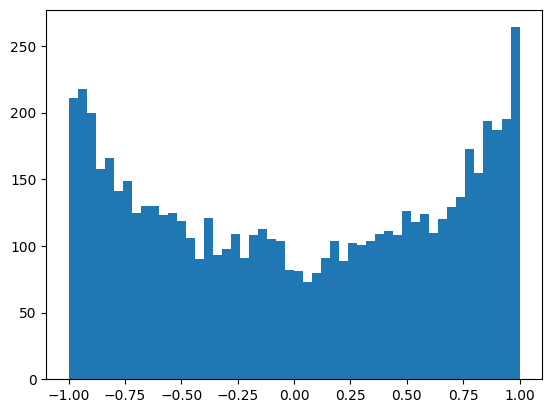

In [83]:
plt.hist(nn.h.view(-1).tolist(), 50);

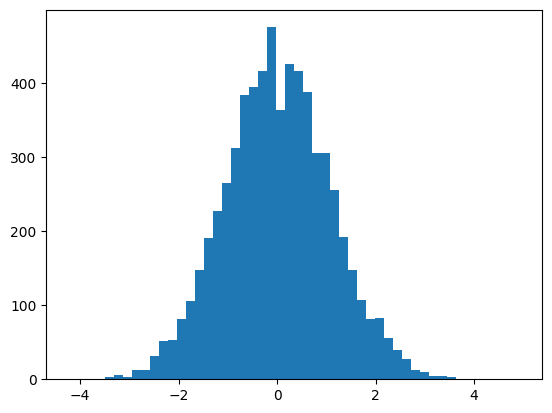

In [84]:
plt.hist(nn.hpreact.view(-1).tolist(), 50);


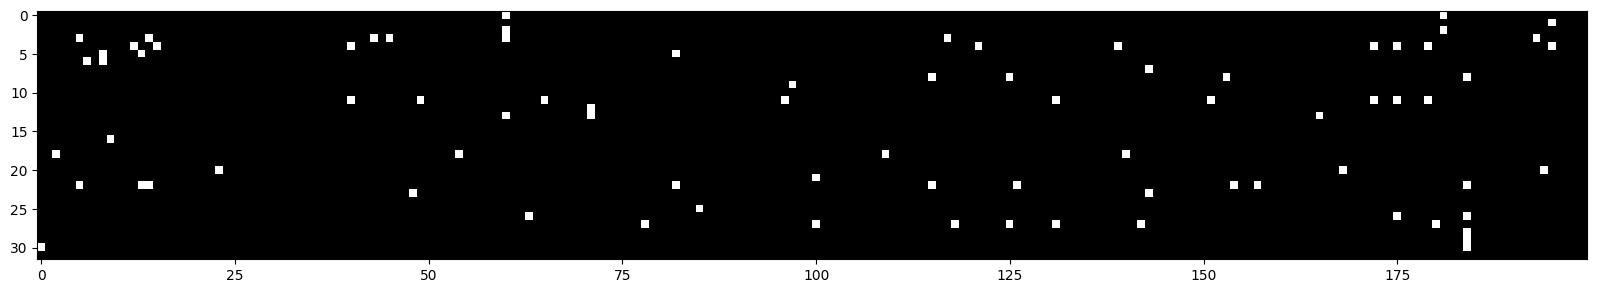

In [85]:
plt.figure(figsize=(20,10));
plt.imshow(nn.h.abs() > 0.99, cmap='gray', interpolation='nearest');

      0/ 200000: 3.7371
  10000/ 200000: 1.7613
  20000/ 200000: 1.4222
  30000/ 200000: 1.8768
  40000/ 200000: 1.4871
  50000/ 200000: 2.2807
  60000/ 200000: 1.7422
  70000/ 200000: 1.5854
  80000/ 200000: 1.9995
  90000/ 200000: 1.4310
 100000/ 200000: 1.7311
 110000/ 200000: 1.4871
 120000/ 200000: 1.3908
 130000/ 200000: 1.3281
 140000/ 200000: 1.5639
 150000/ 200000: 1.7007
 160000/ 200000: 1.6561
 170000/ 200000: 1.1525
 180000/ 200000: 1.7005
 190000/ 200000: 1.4037
train_loss=1.4660104513168335
val_loss=1.657399296760559


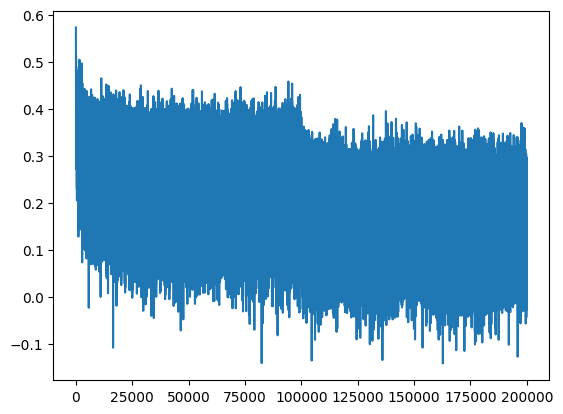

In [86]:
g = torch.Generator().manual_seed(seed)
nn = BengioFFN(e_dims, n_hidden, context_size, words.nb_chars, g)
lossi = nn.train(datasets, max_steps, mini_batch_size)
train_loss = nn.training_loss(datasets)
val_loss = nn.test_loss(datasets)
print(f"{train_loss=}")
print(f"{val_loss=}")
plt.plot(lossi);

Sur un réseau aussi simple que celui que nous avons utilisé ici, les erreurs d'initialisation ont finalement peu d'impact sur la qualité finale du réseau. Par contre, sur des réseaux plus complexes, ces erreurs peuvent empêcher le réseau d'apprendre.

Nous avons pu ici modifier l'initialisation de manière empirique en ajoutant des "nombres magiques" (0.01, 0.2, etc.), mais il existe des techniques plus robustes pour trouver ces améliorations.

### Initialisation "Kaiming"

Plutôt que de choisir "au doigt mouillé" les valeurs initiales à utiliser, il existe des méthodes plus robustes.

- Voir "Kaiming init" <https://arxiv.org/pdf/1502.01852>
- Voir <https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_>
- Voir <https://docs.pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain>

tensor(-0.0177) tensor(1.0071)
tensor(0.0058) tensor(3.2131)


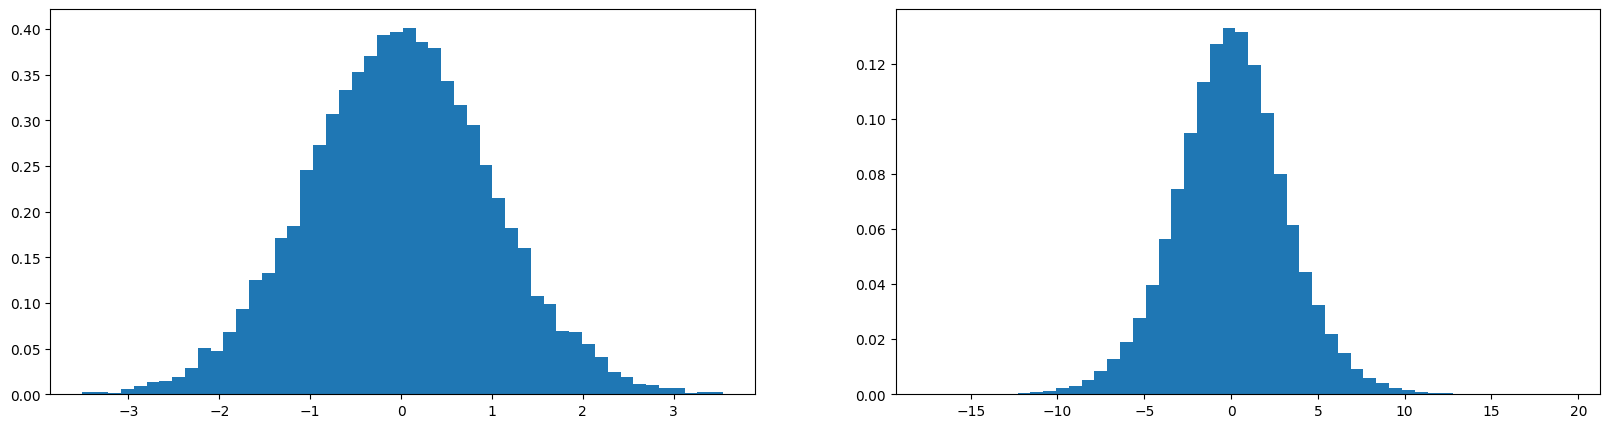

In [89]:
# Exemple pour discuter
x = torch.randn(1000, 10)  # 1000 examples de dimension 10
h = torch.randn(10, 200)  # couche cachée de 200 neurones et de 10 entrées
y = x @ h
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

On voit que la distribution à droite est plus resserée que celle de gauche (regarder les coordonnées...).
On voudrait préserver la distribution, pour que la déviation standard reste proche de 1.

tensor(-0.0151) tensor(1.0040)
tensor(-0.0461) tensor(15.6056)


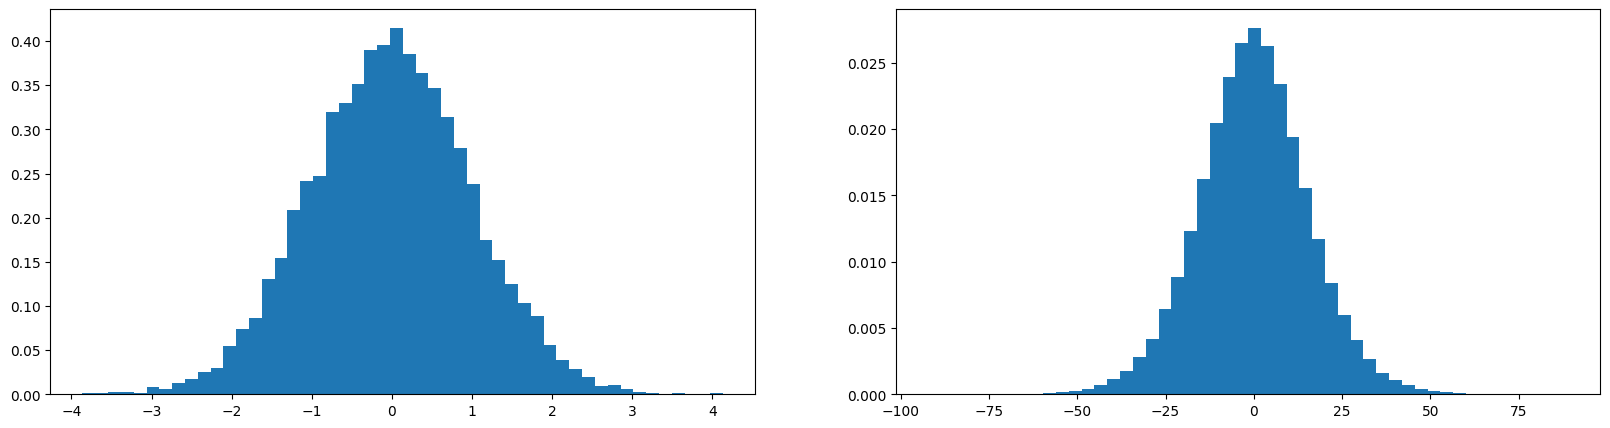

In [93]:
# Exemple pour discuter
x = torch.randn(1000, 10)
h = torch.randn(10, 200) * 5
#h = torch.randn(10, 200) * 0.2
y = x @ h
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

Empiriquement, pour garder la variance il faut diviser par la racine carrée du "fan-in", c'est-à-dire par le nombre d'entrées de chaque neurone:

tensor(-0.0049) tensor(0.9964)
tensor(-0.0029) tensor(1.0097)


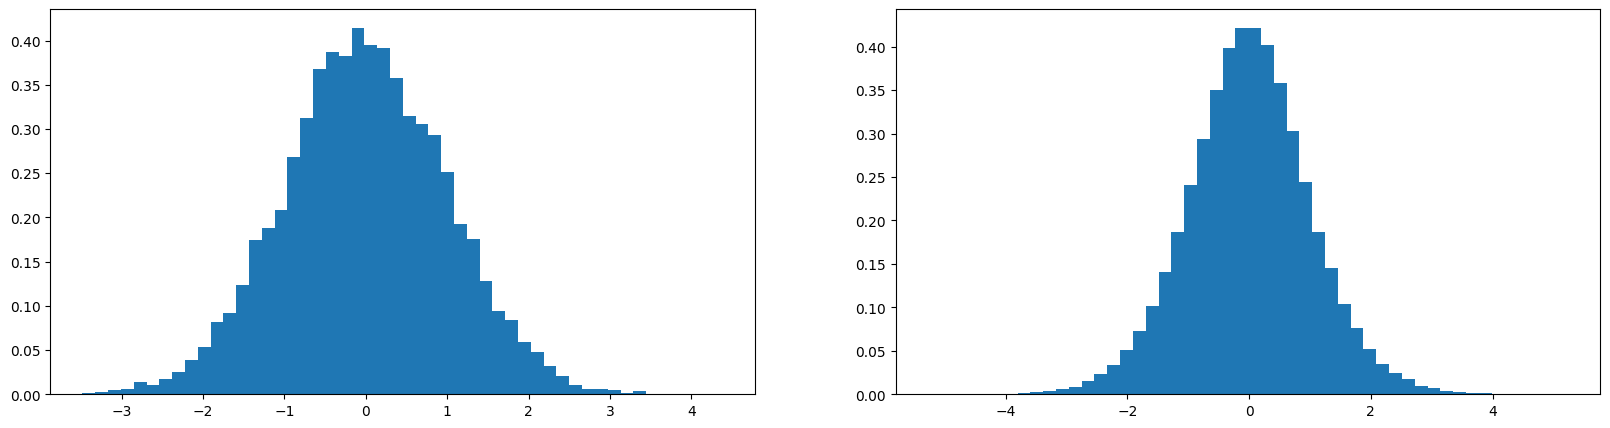

In [94]:
# Exemple pour discuter
fanin = 10
nb_exemples = 1000
n_hidden = 200
x = torch.randn(nb_exemples, fanin)
h = torch.randn(fanin, n_hidden) / fanin**0.5 
y = x @ h
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

Le papier de [Kaiming _et al_](<https://arxiv.org/pdf/1502.01852) présente des valeurs pour régler la déviation standard, reprises dans [PyTorch](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_).

$$\text{std} = \frac{\text{gain}}{\sqrt{\text{fan\_mode}}}$$

avec pour tanh le gain $5/3$ ([torch.nn.init calculate gain](https://docs.pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain)). Dans notre réseau, cela donne environ 0.3:

In [101]:
(5/3) / (30 ** 0.5) 

0.3042903097250923

Nous avions réglé cette valeur de manière empirique à 0.2.

Modifions le code précédent:

In [103]:
def layers(self):
    self.C = torch.randn((self.nb_chars, self.e_dims), generator=self.g)
    fan_in = self.context_size * self.e_dims
    tanh_gain = 5/3
    self.W1 = torch.randn((self.context_size * self.e_dims, self.n_hidden), generator=self.g) * (tanh_gain / (fan_in ** 0.5))
    self.b1 = torch.randn(self.n_hidden, generator=self.g) * 0.01  # un peu d'entropie
    self.W2 = torch.randn((self.n_hidden, self.nb_chars), generator=self.g) * 0.01  # Pour l'entropie
    self.b2 = torch.randn(self.nb_chars, generator=self.g) * 0
BengioFFN.layers = layers

      0/ 200000: 3.7392
  10000/ 200000: 1.7750
  20000/ 200000: 1.3628
  30000/ 200000: 1.8122
  40000/ 200000: 1.5174
  50000/ 200000: 2.2347
  60000/ 200000: 1.7743
  70000/ 200000: 1.5951
  80000/ 200000: 2.1101
  90000/ 200000: 1.4280
 100000/ 200000: 1.7477
 110000/ 200000: 1.6083
 120000/ 200000: 1.3621
 130000/ 200000: 1.3791
 140000/ 200000: 1.5519
 150000/ 200000: 1.6893
 160000/ 200000: 1.5604
 170000/ 200000: 1.1256
 180000/ 200000: 1.6355
 190000/ 200000: 1.4911
train_loss=1.4627671241760254
val_loss=1.657903790473938


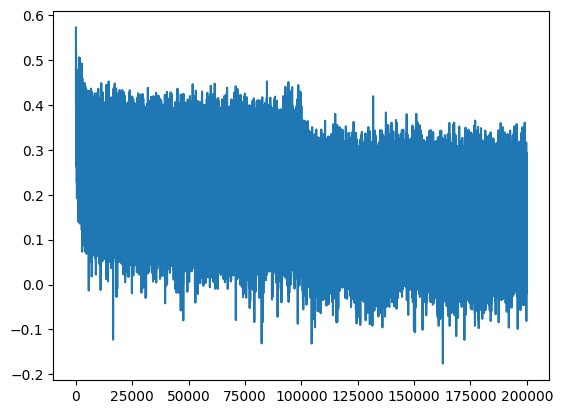

In [104]:
g = torch.Generator().manual_seed(seed)
nn = BengioFFN(e_dims, n_hidden, context_size, words.nb_chars, g)
lossi = nn.train(datasets, max_steps, mini_batch_size)
train_loss = nn.training_loss(datasets)
val_loss = nn.test_loss(datasets)
print(f"{train_loss=}")
print(f"{val_loss=}")
plt.plot(lossi);

Le score est similaire à ce que nous avions fait "à la main", mais cette version permet d'avoir une méthode robuste pour ne pas avoir à trouver nous même le facteur d'initialisation.

Des méthodes plus modernes et robustes existent néanmoins, comme la méthode BatchNorm.

## Méthode BatchNorm

Méthode apparue en 2015 pour entraîner de manière fiable des réseaux avec de nombreuses couches.

- BatchNorm: <https://arxiv.org/abs/1502.03167>
- Illustration de certains problèmes liés à BatchNorm: <https://arxiv.org/abs/2105.07576>

L'article de 2015 "_Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift_" de Sergey Ioffe de Christian Szegedy ([arxiv.org](https://arxiv.org/abs/1502.03167) a introduit la notion de "batch normalisation" qui a permis par la suite d'entraîner des réseaux de grande profondeur de manière beaucoup plus fiable et reproductible.

Dans la couche cachée (celle avec la non-linéarité due à $tanh$), les états de pré-activation `hpreact`:

```python
self.hpreact = self.embcat @ self.W1 + self.b1 # hidden layer pre-activation
```

ne doivent ni être trop petits ni trop grands, sinon ils sont "annulés" par la forme de $tanh$: on souhaiterait que la distribution de ces valeurs suive une loi normale. L'apport du papier de Ioffe et Szegedy est de partir de l'intuition qu'il suffit de normaliser les valeurs à l'initialisation pour qu'ils suivent une loi normale, avec des prescriptions sur la manière de le faire.

Ainsi, le papier indique qu'une normalisation qui "fonctionne bien" à l'initialisation est de partir d'un "batch" d'exemples $\mathcal{B} = {x_1, ..., x_m}$ qui correspondent dans notre code à:

```python
self.emb = self.C[X] # Embed characters into vectors
self.embcat = self.emb.view(self.emb.shape[0], -1) # Concatenate the vectors
self.hpreact = self.embcat @ self.W1 + self.b1 # hidden linear pre-activation layer
```

de faire la moyenne de ces valeurs ($\mu_\mathcal{B} = {1\over m} \sum_{i=1}^m{x_i}$):

```python
self.hpreact.mean(0)
```

et ensuite d'utiliser la variance ($\sigma_\mathcal{B}^2 = {1\over m} \sum_{i=1}^m{(x_i-\mu_\mathcal{B})^2}$) pour normaliser les valeurs avec la formule suivante:

$$\hat{x}_i = {{x_i - \mu_\mathcal{B}}\over{\sqrt{\sigma_\mathcal{B}^2 + \epsilon}}}$$

(avec $\epsilon$ qui permet d'éviter une division par zéro). Cette formule peut se traduire en code par ceci, en utilisant l'écart-type (`std` pour _standard deviation_):

```python
self.hpreact = self.hpreact - self.hpreact.mean(0) / self.hpreact.std(0)
```

Toutes ces fonctions sont dérivables donc nous pouvons calculer nos gradients.

En l’état cette formule est intéressante pour l'initialisation, mais le fait de forcer cette normalisation de cette manière ne va pas permettre d'obtenir de bons résultats lors de l'apprentissage.

Il faudrait adapter la distribution au fur et à mesure, en laissant la back-propagation nous dire quoi faire. L'approche "_scale and shift_" proposée dans le papier utilise la formule suivante:

$$y_i = {\gamma\hat{x}_i+\beta}$$

où $\gamma$ et $\beta$ sont deux nouveaux paramètres que nous allons faire apprendre à notre réseau, que nous appelerons `bngain` et `bnbias`:

```python
## initialisation
self.bngain = torch.ones()
self.bnbias = torch.zeros()
## forward
self.bnmeani = self.hpreact.mean(0, keepdim=True)
self.bnstdi = self.hpreact.std(0, keepdim=True)
self.hpreact = self.bngain * (self.hpreact - self.bnmeani) / self.bnstdi + self.bnbias
```

Cette normalisation de la couche cachée stabilise l’entraînement, en adaptant l’échelle de la couche de pré-activation.

Le prix à payer de cette approche est important: auparavant, chaque exemple avait une contribution indépendante pour l'apprentissage, maintenant sa contribution est reliée à ceux présents dans son batch à cause de la normalisation. En pratique cela permet de rendre l'apprentissage plus régulier quand on a un grand nombre de couches, dans une sorte d'_augmentation de données_ (_data augmentation_).

On peut supprimer `b1` dans le code car lorsque l’on soustrait `bmeani` ils sont annulés.

Cette approche implique également de revoir la manière dont l'inférence fonctionne car nous avons besoin de la valeur de la moyenne
de l'ensemble d'entraînement, ce qui est une opération qui peut être longue:

```python
# calibrate the batch norm at the end of training
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)
```

Une approche plus courante est de "maintenir" cette moyenne et écart-type au cours de l'apprentissage dans la passe "forward":

```python
with torch.no_grad():
    self.bnmean_running = 0.999 * self.bnmean_running + 0.001 * self.bnmeani
    self.bnstd_running = 0.999 * self.bnstd_running + 0.001 * self.bnstdi
```

l'attribut `no_grad` permettant d'indiquer que les variables `*_running` ne font pas partie de notre réseau.


#### Lien avec Pytorch

Pytorch propose des [Linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) qui correspondent aux couches que nous utilisons dans notre réseau: ce sont ces couches que l'on associe à des fonctions d'activation. Ces couches linéaires vont être la plupart du temps "normalisée" afin d'avoir des lois normales similaires en entrée et en sortie avant de passer à la couche non-linéaire.

La couche [BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d) correspond à ce que nous avons utilisé ici.

D'autres couches de normalisation sont utilisées, comme [Layer Normalization](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html), [Group Normalization](https://pytorch.org/docs/stable/generated/torch.nn.GroupNorm.html#torch.nn.GroupNorm).


### Code final

Voici en synthèse le nouveau code de notre réseau, avec l'inférence associée.

In [114]:

def layers(self):
    self.C = torch.randn((self.nb_chars, self.e_dims), generator=self.g)
    fan_in = self.context_size * self.e_dims
    tanh_gain = 5/3
    self.W1 = torch.randn((self.context_size * self.e_dims, self.n_hidden), generator=self.g) * (tanh_gain / (fan_in ** 0.5))
    self.W2 = torch.randn((self.n_hidden, self.nb_chars), generator=self.g) * 0.01  # Pour l'entropie
    self.b2 = torch.randn(self.nb_chars, generator=self.g) * 0
    self.bngain = torch.ones((1, n_hidden))
    self.bnbias = torch.zeros((1, n_hidden))
BengioFFN.layers = layers

def create_network(self):
    self.layers()
    self.loss = None
    self.steps = 0
    self.parameters = [self.C, self.W1, self.W2, self.b2, self.bngain, self.bnbias]
    self.nb_parameters = sum(p.nelement() for p in self.parameters) # number of parameters in total
    for p in self.parameters:
        p.requires_grad = True
    self.bnmean_running = torch.zeros((1, n_hidden))
    self.bnstd_running = torch.zeros((1, n_hidden))
BengioFFN.create_network = create_network

def forward(self, X, Y):
    self.emb = self.C[X] # Embed characters into vectors
    self.embcat = self.emb.view(self.emb.shape[0], -1) # Concatenate the vectors
    # Linear layer
    self.hpreact = self.embcat @ self.W1 # hidden layer pre-activation
    # BatchNorm layer
    self.bnmeani = self.hpreact.mean(0, keepdim=True)
    self.bnstdi = self.hpreact.std(0, keepdim=True)
    self.hpreact = self.bngain * (self.hpreact - self.bnmeani) / self.bnstdi + self.bnbias
    # Non linearity
    self.h = torch.tanh(self.hpreact) # hidden layer
    self.logits = self.h @ self.W2 + self.b2 # output layer
    self.loss = F.cross_entropy(self.logits, Y) # loss function
    # mean, std
    with torch.no_grad():
        self.bnmean_running = 0.999 * self.bnmean_running + 0.001 * self.bnmeani
        self.bnstd_running = 0.999 * self.bnstd_running + 0.001 * self.bnstdi
BengioFFN.forward = forward

@torch.no_grad() # this decorator disables gradient tracking
def compute_loss(self, X, Y):
    emb = self.C[X] # Embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ self.W1 # hidden layer pre-activation
    hpreact = self.bngain * (hpreact - self.bnmean_running) / self.bnstd_running + self.bnbias
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ self.W2 + self.b2 # output layer
    loss = F.cross_entropy(logits, Y) # loss function
    return loss
BengioFFN.compute_loss = compute_loss

@torch.no_grad()
def generate_word(self, itoc, g):
    out = []
    context = [0] * self.context_size
    while True:
        emb = self.C[torch.tensor([context])]
        embcat = emb.view(1, -1)
        hpreact = embcat @ self.W1
        hpreact = self.bngain * (hpreact - self.bnmean_running) / self.bnstd_running + self.bnbias
        h = torch.tanh(hpreact)
        logits = h @ self.W2 + self.b2
        probs = F.softmax(logits, dim=1)
        # Sample from the probability distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # Shift the context window
        context = context[1:] + [ix]
        # Store the generated character
        if ix != 0:
            out.append(ix)
        else:
            # Stop when encounting '.'
            break
    return ''.join(itoc[i] for i in out)
BengioFFN.generate_word = generate_word


## Entraînement

      0/ 200000: 3.7070
  10000/ 200000: 2.1842
  20000/ 200000: 2.0719
  30000/ 200000: 2.0493
  40000/ 200000: 2.0728
  50000/ 200000: 1.8556
  60000/ 200000: 1.9816
  70000/ 200000: 1.6609
  80000/ 200000: 1.5744
  90000/ 200000: 2.1140
 100000/ 200000: 1.8943
 110000/ 200000: 1.5171
 120000/ 200000: 1.8516
 130000/ 200000: 1.5455
 140000/ 200000: 1.3465
 150000/ 200000: 1.3427
 160000/ 200000: 1.6364
 170000/ 200000: 1.9168
 180000/ 200000: 1.5088
 190000/ 200000: 1.6241
train_loss=1.5353056192398071
val_loss=1.6674079895019531


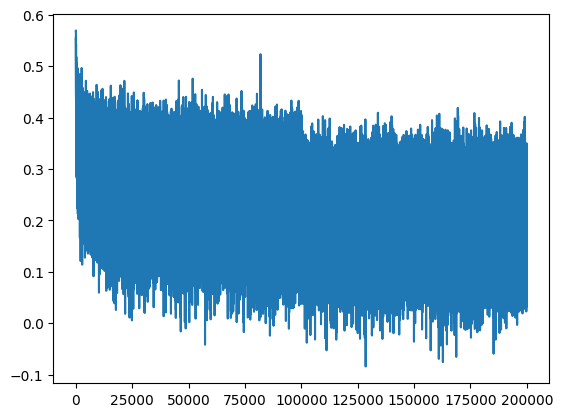

In [115]:
g = torch.Generator().manual_seed(seed)
nn = BengioFFN(e_dims, n_hidden, context_size, words.nb_chars, g)
lossi = nn.train(datasets, max_steps, mini_batch_size)
train_loss = nn.training_loss(datasets)
val_loss = nn.test_loss(datasets)
print(f"{train_loss=}")
print(f"{val_loss=}")
plt.plot(lossi);

## Génération

In [116]:
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    word = nn.generate_word(words.itoc, g)
    print(word)

aves
des
saien
impôt
récialir
empêchercise
ubularieu
artenue
soire
assume
unitorigrogré
momentes
judividarf
soument
lohes
facirié
alte
jours
océ
déritestiture


## Synthèse des scores de loss

*Origine*

```
train_loss=1.4996627569198608
val_loss=1.7031011581420898
```

*Initialisation correcte de la couche de sortie*

```
train_loss=1.4785451889038086
val_loss=1.6728813648223877
```

*Initialisation correcte de la couche cachée pour tanh*

```
train_loss=1.4660104513168335
val_loss=1.657399296760559
```

*Initialisation correcte de la couche cachée méthode Kaiming*

```
train_loss=1.4627671241760254
val_loss=1.657903790473938
```

*BatchNorm*

```
train_loss=1.5353056192398071
val_loss=1.6674079895019531
```

## Torch-ification

### Linear

In [ ]:
class Linear:
    """Linear layer.
    
    Similar to <https://pytorch.org/docs/stable/generated/torch.nn.Linear.html>
    """
    def __init__(self, fan_in, fan_out, g, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

### BatchNorm1d

In [118]:
class BatchNorm1d:
    """Batch normalization layer.
    
    Similar to <https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d>
    """
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

### Tanh

In [119]:
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

### Réseau profond

In [121]:
vocab_size = words.nb_chars
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the FFN
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * context_size, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer: make less confident
    #layers[-1].gamma *= 0.1
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            #layer.weight *= 1.0
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

48051


### Entraînement

In [122]:
def train(X, Y, C, layers, max_steps, batch_size, g):
    lossi = []
    ud = []
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
        Xb, Yb = X[ix], Y[ix]
        
        # forward pass
        emb = C[Xb] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    return lossi, ud

In [124]:
max_steps = 1
batch_size = 32
lossi, ud = train(datasets.Xtr, datasets.Ytr, C, layers, max_steps, batch_size, g)

      0/      1: 3.7015
